# Import

In [95]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datasets import load_dataset, get_dataset_split_names
from transformers import AutoTokenizer, AutoModel, pipeline

---

# Working with Transformers in the HuggingFace Ecosystem

In this laboratory exercise we will learn how to work with the HuggingFace ecosystem to adapt models to new tasks. As you will see, much of what is required is *investigation* into the inner-workings of the HuggingFace abstractions. With a little work, a little trial-and-error, it is fairly easy to get a working adaptation pipeline up and running.

### Exercise 1: Sentiment Analysis (warm up)

In this first exercise we will start from a pre-trained BERT transformer and build up a model able to perform text sentiment analysis. Transformers are complex beasts, so we will build up our pipeline in several explorative and incremental steps.

#### Exercise 1.1: Dataset Splits and Pre-trained model
There are a many sentiment analysis datasets, but we will use one of the smallest ones available: the [Cornell Rotten Tomatoes movie review dataset](cornell-movie-review-data/rotten_tomatoes), which consists of 5,331 positive and 5,331 negative processed sentences from the Rotten Tomatoes movie reviews.

**Your first task**: Load the dataset and figure out what splits are available and how to get them. Spend some time exploring the dataset to see how it is organized. Note that we will be using the [HuggingFace Datasets](https://huggingface.co/docs/datasets/en/index) library for downloading, accessing, splitting, and batching data for training and evaluation.

In [56]:
ds = 'cornell-movie-review-data/rotten_tomatoes'
get_dataset_split_names(ds)
ds_train = load_dataset(ds, split='train')
ds_val = load_dataset(ds, split='validation')
ds_test = load_dataset(ds, split='test')


In [98]:
print(ds_train)
print(ds_val)
print(ds_test)
print('\n')
print(f'- Freatures: {ds_train.features}')
print(f'- Possibili valutazioni: {np.unique(ds_train["label"])}')
print(f'- Elemento 0: {ds_train[0]}')
print(f'- Elemento 5756: {ds_train[5756]}')


Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})
Dataset({
    features: ['text', 'label'],
    num_rows: 1066
})
Dataset({
    features: ['text', 'label'],
    num_rows: 1066
})


- Freatures: {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}
- Possibili valutazioni: [0 1]
- Elemento 0: {'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}
- Elemento 5756: {'text': 'bottom-rung new jack city wannabe .', 'label': 0}


**Analisi**

Il dataset rappresenta una serie di recenzioni con l'etichetta ad essa assegnata.
- Vediamo che il trainset ha 8530 istanze, mentre il validation e test set ahnno entrambe 1066. Si tratta quindi di una divisione 80%, 10% e 10% rispettivaente.
- Possiamo notare che ad ogni recensizone è associata un'etichetta: 0 significa relazione negativa, 1 inevce relazione positiva. Questo ci è chiaro anche analizzando il primo e uno degli ultimi esempi del dataset.

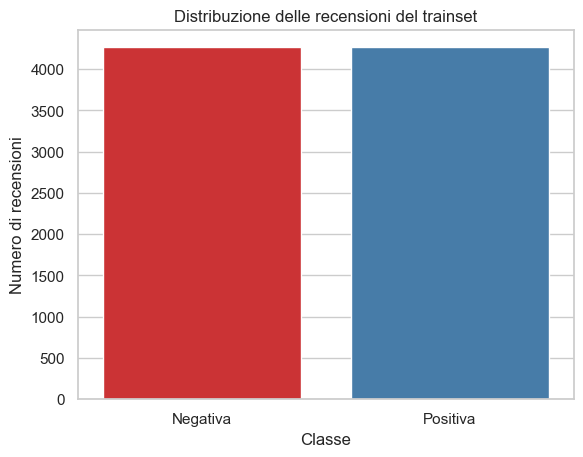

In [ ]:
labels = ds_train['label']
palette = sns.color_palette('Set1', 2)
plt.figure()
plt.title("Distribuzione delle recensioni del trainset")
plt.xlabel('Classe')
plt.ylabel('Numero di recensioni')
plt.xticks([0, 1], ['Negativa', 'Positiva'])
sns.countplot(x=labels, hue=labels, palette=palette, legend=False)
plt.show()

# if(false):
#   percorso_file = dowload_path + 'distribuzione MNIST.pdf'
#   plt.savefig(percorso_file, dpi=300, bbox_inches='tight')

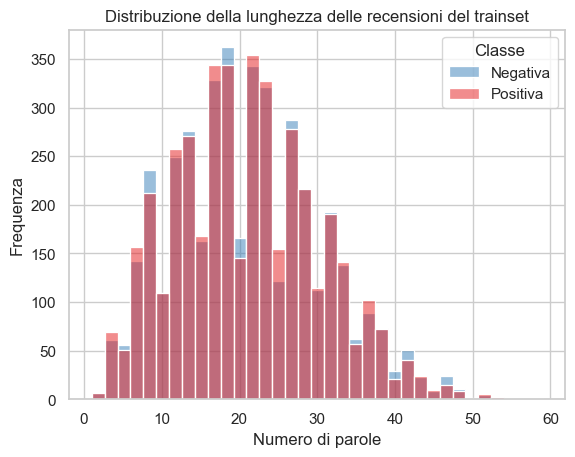

In [86]:
review_lengths = [len(text.split()) for text in ds_train['text']]
palette = sns.color_palette('Set1', 2)
plt.figure()
sns.histplot(x=review_lengths, hue=ds_train['label'], bins=35, palette=palette, kde=False)
plt.title("Distribuzione della lunghezza delle recensioni del trainset")
plt.xlabel('Numero di parole')
plt.ylabel('Frequenza')
plt.legend(title='Classe', labels=['Negativa', 'Positiva'])
plt.show()

# if(false):
#   percorso_file = dowload_path + 'distribuzione MNIST.pdf'
#   plt.savefig(percorso_file, dpi=300, bbox_inches='tight')

**Analisi**

Dai due grafici sopra:
- Possiamo vedere che le recensioni sono perfettamente bilanciate tra negative e positive.
- È compicato stabile una relazione tra lunghezza delle recensioni e la loro qualità. Possiamo però notare che le recensioni più corte di 5/6 parle e più lunghe di 40 sono poche.

#### Exercise 1.2: A Pre-trained BERT and Tokenizer

The model we will use is a *very* small BERT transformer called [Distilbert](https://huggingface.co/distilbert/distilbert-base-uncased) this model was trained (using self-supervised learning) on the same corpus as BERT but using the full BERT base model as a *teacher*.

**Your next task**: Load the Distilbert model and corresponding tokenizer. Use the tokenizer on a few samples from the dataset and pass the tokens through the model to see what outputs are provided. I suggest you use the [`AutoModel`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html) class (and the `from_pretrained()` method) to load the model and `AutoTokenizer` to load the tokenizer).

In [ ]:
# Your code here.
model_id = 'distilbert/distilbert-base-uncased'
model = AutoModel.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
model

se abbiamo guardato il video allora sappiamo cosa sono. prima si fa l'embedding e poi si passa tramite i blocchi di self attention.
il modello berd produce per ogni token in input una sua rappresentazione. Se dobbaimo fare un qualcosa tra i vari moduli allora ci conviene usare modullist e non sequential.

In [ ]:
tokenizer

i token aggiunti sono importanti perchè sono aggiunti e magari dobbiamo farci qualcosa.

In [ ]:
tokenizer(ds_train[0]['text'])

In [ ]:
tokenizer(ds_train[:5]['text'], padding=True) # i testi non hanno la stessa lunghezza; se vogliamo fare l'inferenza o fine tuning a batch alloara dobbaimo indicare al modello quali sono i token validi, il vero contenuto. se un testo è più corto di un altro allora vengono messi dei padding e degli 0 nell'attestion mask. se stampiamo tokenizer allora vediamo che 0 è il token di PAD.

tokenizer(ds_train[:2]['text'], padding=True, return_tensors='pt') #converte gli input_id e l'attention mask in tensori

In [ ]:
input = tokenizer(ds_train[:2]['text'], padding=True, return_tensors='pt')
output = model(**input)
output

ho un base model output che è un dizionario ordered che contiene solo una chiave (last_hiden_state) che ne gergo dei transformers vuol dire l'ultimo layer del modul trasformers (dei 6 in questo modello).

In [ ]:
hidden_state = output['last_hidden_state']
hidden_state.shape

# ho due frasi in input e ho 52 token in out trasformati. se dobbiamo fare sentiment analisis allora non possiamo usare tutti i token. in bert abbiamo un token speciale che è CLS (class token) vhe viene aggiunto all'inizio che viene inserito per aggiungere una rappresentazione di ogni layer. se riusciamo ad individuare questo class token poi lo possiamo utilizzre; per essere sicuro di quale di questi 52 è questo che ci interessa si fa quanto segue.

In [ ]:
tokenizer.decode(input['input_ids'][0]) # il primo token è il class token, il secondo è il primo token della frase. se vogliamo fare sentiment analysis allora possiamo usare solo il class token. per fare questo dobbiamo estrarre il class token da hidden state e fare la media di tutti i token che abbiamo in hidden state. in questo modo otteniamo una rappresentazione del class token che possiamo usare per fare la sentiment analysis.

posso decodificare per avere il testo indietro. in questo modo si inverte la tokenizzazione inserindo padding e il primo token inserito è CLS. quando faccimao un fordward pass che produce tutti i token trasformati, allora il pirmo nel last hidden layer è questo e voglio usarlo per fare sentiment analisys. Invece di usare questo si potrebbe fare un avgpooling o un maxpooling di tutti i token del last hidden layer.

quello che il CLS contiene è la sentiment analisis. dobbiamo usare distibert come featuees extractor.

#### Exercise 1.3: A Stable Baseline

In this exercise I want you to:
1. Use Distilbert as a *feature extractor* to extract representations of the text strings from the dataset splits;
2. Train a classifier (your choice, by an SVM from Scikit-learn is an easy choice).
3. Evaluate performance on the validation and test splits.

These results are our *stable baseline* -- the **starting** point on which we will (hopefully) improve in the next exercise.

**Hint**: There are a number of ways to implement the feature extractor, but probably the best is to use a [feature extraction `pipeline`](https://huggingface.co/tasks/feature-extraction). You will need to interpret the output of the pipeline and extract only the `[CLS]` token from the *last* transformer layer. *How can you figure out which output that is?*

pipeline permette di prendere un modello e un tokenizer e usarli come features extractor. in realtà ci sono un sacco di pipeline pre definite (es: feature-extraction, text-classification).

In [ ]:
# Your code here.
extractor = pipeline('feature-extraction', model=model, tokenizer=tokenizer)

In [ ]:
foo = extractor(ds_train[:5]['text'], return_tensors='pt')
foo[0].shape, foo[2].shape

In [ ]:
def extract_features(ds):
    feats = extractor(ds['text'], return_tensors='pt')
    return torch.vstack([feat[0][0] for feat in feats])

# extract all fetures
Xs_train = extract_features(ds_train)
ys_train = ds_train['label']
Xs_val = extract_features(ds_val)
ys_val = ds_val['label']
Xs_test = extract_features(ds_test)
ys_test = ds_test['label']

In [ ]:
Xs_train.shape, Xs_val.shape, Xs_test.shape

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

svc = LinearSVC()
svc.fit(Xs_train, ys_train)
print(classification_report(ys_val, svc.predict(Xs_val), target_names=['negative', 'positive']))
print(classification_report(ys_test, svc.predict(Xs_test), target_names=['negative', 'positive']))

abbiamo raggiunto un 80%. se raggiungiamo un 60% allora vuol dire che abbiamo qualcosa di sbagliato. questo è un baseline e ora dobbiamo finetuning.

per molte applicazione le features pre addestrate potrebbero funzionare benissimo, magari usando un MLP e non un svm.

-----
### Exercise 2: Fine-tuning Distilbert

In this exercise we will fine-tune the Distilbert model to (hopefully) improve sentiment analysis performance.

#### Exercise 2.1: Token Preprocessing

The first thing we need to do is *tokenize* our dataset splits. Our current datasets return a dictionary with *strings*, but we want *input token ids* (i.e. the output of the tokenizer). This is easy enough to do my hand, but the HugginFace `Dataset` class provides convenient, efficient, and *lazy* methods. See the documentation for [`Dataset.map`](https://huggingface.co/docs/datasets/v3.5.0/en/package_reference/main_classes#datasets.Dataset.map).

**Tip**: Verify that your new datasets are returning for every element: `text`, `label`, `intput_ids`, and `attention_mask`.

vogliamo arricchicchire il dataset per fare la tokenizzazione. adesso abbiamo testo e etichette; il tokeniziner non cambia mai durante il finetuning perchè non lo stiamo addestrando. vogliamo modificare il dataset in modo che restituisca anche inputs_id e attention mask.

dataset.map applica una funzione a ogni elemento del dataset. vogliamo per ogni elemento tokenizziare e agginugere quelle cose.

In [ ]:
# Your code here.

def preprocess_function(example):
    return tokenizer(example['text'], padding=True, return_tensors='pt')

# dataset map are not performed in-place. viene quindi creata un altra copia.
tokenized_train = ds_train.map(preprocess_function, batched=True)
tokenized_val = ds_val.map(preprocess_function, batched=True)

In [ ]:
tokenized_train[0]

ha riconvertito tutto in una lista.

#### Exercise 2.2: Setting up the Model to be Fine-tuned

In this exercise we need to prepare the base Distilbert model for fine-tuning for a *sequence classification task*. This means, at the very least, appending a new, randomly-initialized classification head connected to the `[CLS]` token of the last transformer layer. Luckily, HuggingFace already provides an `AutoModel` for just this type of instantiation: [`AutoModelForSequenceClassification`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification). You will want you instantiate one of these for fine-tuning.

dobbiamo ora istanziare il modello da finetuning. non possiamo fare come prima perchè prima ha caricato il modello e basta. se facciamo come sotto allora abbiamo. mi dice anche il warning utile.

In [ ]:
# Your code here.
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)

#### Exercise 2.3: Fine-tuning Distilbert

Finally. In this exercise you should use a HuggingFace [`Trainer`](https://huggingface.co/docs/transformers/main/en/trainer) to fine-tune your model on the Rotten Tomatoes training split. Setting up the trainer will involve (at least):


1. Instantiating a [`DataCollatorWithPadding`](https://huggingface.co/docs/transformers/en/main_classes/data_collator) object which is what *actually* does your batch construction (by padding all sequences to the same length).
2. Writing an *evaluation function* that will measure the classification accuracy. This function takes a single argument which is a tuple containing `(logits, labels)` which you should use to compute classification accuracy (and maybe other metrics like F1 score, precision, recall) and return a `dict` with these metrics.  
3. Instantiating a [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.51.1/en/main_classes/trainer#transformers.TrainingArguments) object using some reasonable defaults.
4. Instantiating a `Trainer` object using your train and validation splits, you data collator, and function to compute performance metrics.
5. Calling `trainer.train()`, waiting, waiting some more, and then calling `trainer.evaluate()` to see how it did.

**Tip**: When prototyping this laboratory I discovered the HuggingFace [Evaluate library](https://huggingface.co/docs/evaluate/en/index) which provides evaluation metrics. However I found it to have insufferable layers of abstraction and getting actual metrics computed. I suggest just using the Scikit-learn metrics...

ora abbiamo tokenizzato indipendente ogni elemento del dataset. il datacollector mette insieme i batch in modo che quando vengono forniti alla forware pass in modo corretto.

train argument è un dizionario che contiene tutti i parametri di addestramento.

evaluete librery non ha molto senso ma si possono usare semplicemente le metriceh di sklearn.

In [ ]:
# Your code here.
import numpy as np
import evaluate
from transformers import DataCollatorWithPadding

data_collactor = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    load_accuracy = evaluate.load('accuracy')
    load_f1 = evaluate.load('f1')
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    acc = load_accuracy.compute(predictions=predictions, references=labels)['accuracy']
    f1 = load_f1.compute(predictions=predictions, references=labels)['f1']
    return {'accuracy': acc, 'f1': f1}

qui c'era altro codice suo.

fare un checkpoint ogni epoca è un po' eccissivo.

In [ ]:
trainer.train()

-----
### Exercise 3: Choose at Least One


#### Exercise 3.1: Efficient Fine-tuning for Sentiment Analysis (easy)

In Exercise 2 we fine-tuned the *entire* Distilbert model on Rotten Tomatoes. This is expensive, even for a small model. Find an *efficient* way to fine-tune Distilbert on the Rotten Tomatoes dataset (or some other dataset).

**Hint**: You could check out the [HuggingFace PEFT library](https://huggingface.co/docs/peft/en/index) for some state-of-the-art approaches that should "just work". How else might you go about making fine-tuning more efficient without having to change your training pipeline from above?

In [ ]:
# Your code here.

usando bene required_grad si potrebbe adddestrare solo gli ultimi layer. devo vedere se addestrando tutto si ha overfitting e poi addetsrare solo gli ultimi layer e vedere che non si ha overfitting.

#### Exercise 3.2: Fine-tuning a CLIP Model (harder)

Use a (small) CLIP model like [`openai/clip-vit-base-patch16`](https://huggingface.co/openai/clip-vit-base-patch16) and evaluate its zero-shot performance on a small image classification dataset like ImageNette or TinyImageNet. Fine-tune (using a parameter-efficient method!) the CLIP model to see how much improvement you can squeeze out of it.

**Note**: There are several ways to adapt the CLIP model; you could fine-tune the image encoder, the text encoder, or both. Or, you could experiment with prompt learning.

**Tip**: CLIP probably already works very well on ImageNet and ImageNet-like images. For extra fun, look for an image classification dataset with different image types (e.g. *sketches*).

In [ ]:
# Your code here.

#### Exercise 3.3: Choose your Own Adventure

There are a *ton* of interesting and fun models on the HuggingFace hub. Pick one that does something interesting and adapt it in some way to a new task. Or, combine two or more models into something more interesting or fun. The sky's the limit.

**Note**: Reach out to me by email or on the Discord if you are unsure about anything.

In [ ]:
# Your code here.